In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision.transforms.functional as TF

from src.datasets import MyDataset
from utils.helper import visualize_dataset
from utils.config import WorldStrat_path, DEVICE
from torch.utils.data import DataLoader
from models.network_swinir import SwinIR

print(f'Dvice: {DEVICE}')
dataset = MyDataset(WorldStrat_path)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

Dvice: cuda


torch.Size([3, 1088, 1088])


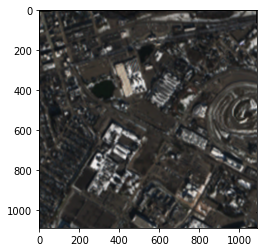

In [2]:
print(dataset[0][0].shape)
plt.imshow(dataset[10][0].permute(1, 2, 0).numpy())


In [3]:
upscale = 4
window_size = 8
height = (500 // upscale // window_size + 1) * window_size
width = (500 // upscale // window_size + 1) * window_size
model = SwinIR(upscale=8, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')

model.to(DEVICE)

model.load_state_dict(torch.load('model_zoo/swinir.pth', map_location=DEVICE))

c:\Users\jiawe\miniconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [3]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def train(epochs, model, dataloader, criterion, optimizer, device, save_path=None):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(dataloader):
            hr, lr = batch
            hr, lr = hr.to(device), lr.to(device)
            optimizer.zero_grad()
            output = model(lr)
            loss = criterion(output, hr)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'epoch: {epoch}, loss: {total_loss / len(dataloader)}')
        if save_path is not None:
            torch.save(model.state_dict(), save_path)

train(100, model, train_loader, criterion, optimizer, DEVICE, save_path='model_zoo/swinir.pth')

100%|██████████| 900/900 [05:29<00:00,  2.74it/s]


epoch: 0, loss: 0.017253234765181938


100%|██████████| 900/900 [05:20<00:00,  2.81it/s]


epoch: 1, loss: 0.012862956120322148


100%|██████████| 900/900 [05:21<00:00,  2.80it/s]


epoch: 2, loss: 0.010882016117684544


100%|██████████| 900/900 [05:19<00:00,  2.82it/s]


epoch: 3, loss: 0.00947505858209398


100%|██████████| 900/900 [05:20<00:00,  2.81it/s]


epoch: 4, loss: 0.009139344502861302


100%|██████████| 900/900 [05:24<00:00,  2.78it/s]


epoch: 5, loss: 0.008280154100050115


100%|██████████| 900/900 [05:19<00:00,  2.81it/s]


epoch: 6, loss: 0.007835156651368986


100%|██████████| 900/900 [05:32<00:00,  2.71it/s]


epoch: 7, loss: 0.0078046227945014835


100%|██████████| 900/900 [05:24<00:00,  2.77it/s]


epoch: 8, loss: 0.00738084897528299


100%|██████████| 900/900 [05:25<00:00,  2.77it/s]


epoch: 9, loss: 0.007039592981907643


100%|██████████| 900/900 [05:26<00:00,  2.76it/s]


epoch: 10, loss: 0.006835227412068182


 23%|██▎       | 203/900 [01:13<04:12,  2.76it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


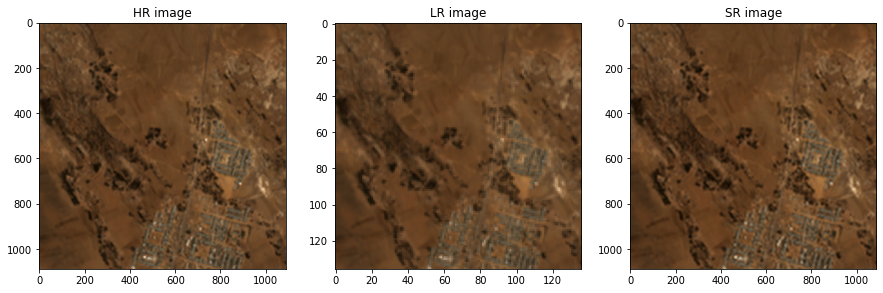

In [11]:
model.eval()
with torch.no_grad():
    for batch in train_loader:
        hr, lr = batch
        hr = hr.to(DEVICE)
        lr = lr.to(DEVICE)
        res = model(lr)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(hr[0].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title('HR image')
        ax[1].imshow(lr[0].permute(1, 2, 0).cpu().numpy())
        ax[1].set_title('LR image')
        ax[2].imshow(res[0].permute(1, 2, 0).cpu().detach().numpy())
        ax[2].set_title('SR image')
        plt.show()

        break

In [20]:
def save_result(path_folder):
    model.eval()
    with torch.no_grad():
        for batch in train_loader:
            hr, lr = batch
            hr = hr.to(DEVICE)
            lr = lr.to(DEVICE)
            res = model(lr)

            hr = cv2.cvtColor(hr[0].permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR) * 255
            lr = cv2.cvtColor(lr[0].permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR) * 255
            res = cv2.cvtColor(res[0].permute(1, 2, 0).cpu().detach().numpy(), cv2.COLOR_RGB2BGR) * 255

            cv2.imwrite(os.path.join(path_folder, 'hr.png'), hr)
            cv2.imwrite(os.path.join(path_folder, 'lr.png'), lr)
            cv2.imwrite(os.path.join(path_folder, 'res.png'), res)
    
            break
    
save_result('./results')